In this notebook we are only considering the tag data, and not loading the associated document text. Each document has the following meta data:

* One or more tags types
* Count for the number of users which tagged that document
* Proportion of users which used a particular tag for a particular document

In [1]:
import json
from pathlib import Path
from collections import Counter 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
from sklearn.feature_extraction import DictVectorizer 
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.plotly as py

from scipy.cluster.hierarchy import dendrogram, linkage

init_notebook_mode(connected=True)
%matplotlib inline 

In [2]:
TAGS_PATH = Path('../../data/wiki10/tags.json')

In [3]:
with TAGS_PATH.open() as fileobj:
    tag_meta_dict = json.load(fileobj)

Example tag data for a single document

In [4]:
tag_meta_dict[list(tag_meta_dict)[0]]

{'tags': {'design': 0.2857142857142857, 'history': 0.35714285714285715},
 'title': 'Hermann Zapf',
 'user_count': '14'}

In [5]:
tag_dict_list = [meta['tags'] for meta in tag_meta_dict.values()]

In [6]:
tag_counts = Counter(tag for tag_dict in tag_dict_list for tag in tag_dict.keys())  

In [7]:
tag_counts.most_common()

[('history', 3829),
 ('science', 2610),
 ('programming', 2062),
 ('people', 1901),
 ('philosophy', 1856),
 ('culture', 1803),
 ('art', 1627),
 ('politics', 1554),
 ('software', 1550),
 ('design', 1492),
 ('language', 1390),
 ('books', 1354),
 ('technology', 1338),
 ('psychology', 1293),
 ('music', 1286),
 ('development', 1241),
 ('math', 1238),
 ('theory', 1157),
 ('religion', 1149),
 ('computer', 1132),
 ('literature', 1089),
 ('business', 1058),
 ('education', 1037),
 ('writing', 1003),
 ('health', 986),
 ('economics', 897),
 ('web', 887),
 ('mathematics', 880),
 ('internet', 857),
 ('english', 794),
 ('architecture', 747),
 ('book', 737),
 ('film', 725),
 ('linux', 715),
 ('reading', 715),
 ('biography', 688),
 ('physics', 683),
 ('games', 670),
 ('opensource', 636),
 ('travel', 630),
 ('security', 608),
 ('movies', 600),
 ('tech', 592),
 ('words', 590),
 ('list', 583),
 ('network', 581),
 ('management', 579),
 ('hardware', 559),
 ('video', 552),
 ('biology', 550),
 ('media', 539),


#### Objective 

We have 73 tag types in total with some that are clearly related (e.g. 'artist/artists' or 'programming/software'). Our objective is to reduce the number of tags types by merging together related tags. As we have multiple tag types per document we can think of the task as feature reduction where our tags are "features". The purpose of this is to make validation of our doc2vec regions easier as we will have fewer classes to plot. 

We start by creating a "feature" matrix for our tags with documents as rows and tags as columns.  

In [8]:
dvec = DictVectorizer()
M_tag = dvec.fit_transform(tag_dict_list).toarray()

In [9]:
M_tag.shape

(19691, 73)

Plotting dot product between each tag vector to show similarity between tag types

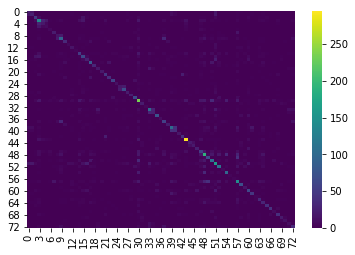

In [10]:
seaborn.heatmap(M_tag.T @ M_tag, cmap='viridis') 

The heatmap showing the dot product between tag occurrences is skewed towards those which are more frequent. Will divide each vector by its l2 norm to show the cosine similarity between vectors. 

In [11]:
# n.b. could have also used sklearn.preprocessing.normalize
def matrix_cosine(A, B):
    dot = A @ B
    A_l2 = np.sqrt(np.sum(A * A, axis=1))
    B_l2 = np.sqrt(np.sum(B * B, axis=0))
    prod_l2 = A_l2.reshape(-1,1) @ B_l2.reshape(1,-1)
    return dot / prod_l2

In [12]:
M_cosine = matrix_cosine(M_tag.T, M_tag)

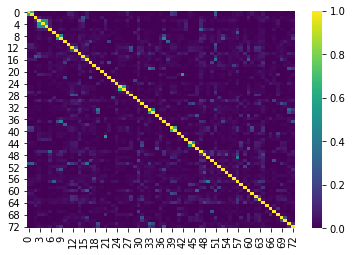

In [13]:
seaborn.heatmap(M_cosine, cmap='viridis') 

This is better and we can start to see correlations between a wider range of tag types, but the heatmap is still dominated by the similarity (=1) on the lead diagonal. Will improve this by replacing diagonal values with 0, for display purposes only. 

In [14]:
np.fill_diagonal(M_cosine, 0) 

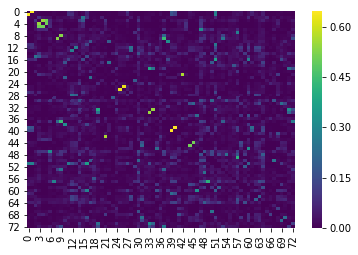

In [15]:
seaborn.heatmap(M_cosine, cmap='viridis')  

Much better, will now add tag labels to plot and make it interactive 

In [16]:
tag_index = dvec.feature_names_

trace = go.Heatmap(
    x=tag_index, 
    y=tag_index, 
    z=M_cosine, 
    colorscale='Viridis'
   ) 

data=[trace]  
iplot(data) 

We can now clearly see correlations between specific tag types, which we could now use to reduce our taxonomy of tags by manually creating new groups of tags. 

However we can make this process easier by applying hierarchical clustering to find groups of tags in a less heuristic way. 

In [17]:
def plot_dendogram(Z):
    plt.figure(figsize=(20, 5))
    dendrogram(
        Z,
        leaf_rotation=90.,  
        leaf_font_size=10., 
        labels=tag_index
    )
    plt.show()

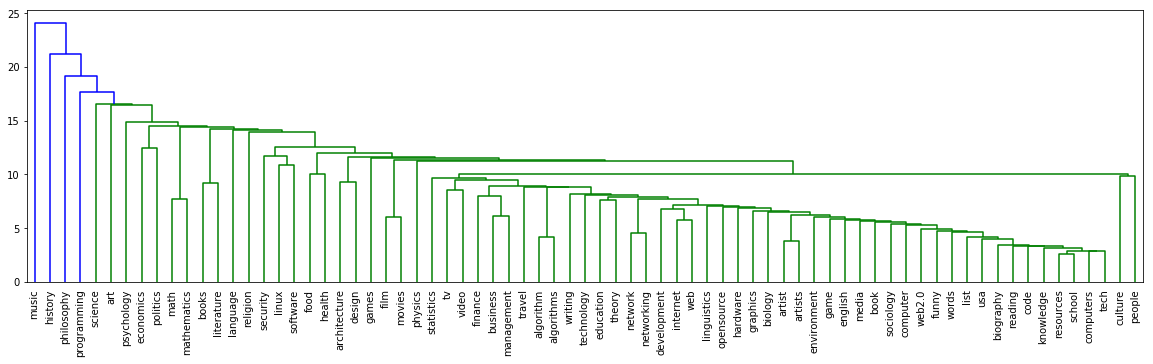

In [18]:
Z = linkage(M_tag.T, method='ward')
plot_dendogram(Z)

The clustering algorithm starts off by defining an individual cluster for each observation (tag type), then creating a new cluster between the "closest" pair of existing clusters, where distance is defined by some method/metric. It then repeats, merging existing clusters in order of distance until all observations are linked. 

The dendogram plot shows the defined linkages, with the x-axis showing observations, and the y-axis showing distance. The first clusters to be defined have the smallest y-value (lowest horizontal bar) and the final linkage has the largest y-value. We can then choose a y-value cutoff which best split our data. This value *can* be estimated  programmatically (which is what the colours on the plot relate to), but we will ignore this and pick out own.

The **ward** method uses a statistical approach to picking clusters, and achieves this by choosing (at each step) the linkage which minimize in-cluster variance of **euclidean** distance between cluster observations. It appears to be doing a fairly good job here with many linkages looking sensible. However we notice that there are some splits which do not make sense, for example there is a large distance between 'art' and 'artist/artists'. Also we see the tags which are clustered last (history/philosophy...) are amongst the most frequent tag types (i.e. have vectors with largest magnitude). This makes sense as the euclidean distance will not compensate for unnormalized inputs (and in fact will exaggerate the effect).

In place of euclidean distance as our metric we will try using **cosine** distance, as this L2 normalises the inputs, to hopefully give a more balanced result. As the scipy "ward" method only supports euclidean distance we will have to use a different method, and so will try **single** linkage, **average** linkage and **complete** linkage.

The general approach behind these methods is the same as "ward", apart from the way the in which the next linkage is chosen. Consider clusters A1 and A2 which are picked to be merged in the next linkage step:

* **ward**: Variance of distance between all points in A1 & A2 must be smaller than any other Ai & Aj
* **single**: The *closest* pair of points, where one exists in A1 and one exists in A2, must be closer than any other closest pair from Ai & Aj
* **complete**: The *farthest* pair of points, where one exists in A1 and one exists in A2, l much be closer than any other farthest pair from Ai & Aj
* **average**: Like "ward but the average distance between all pairs in the new cluster is considered instead of the variance

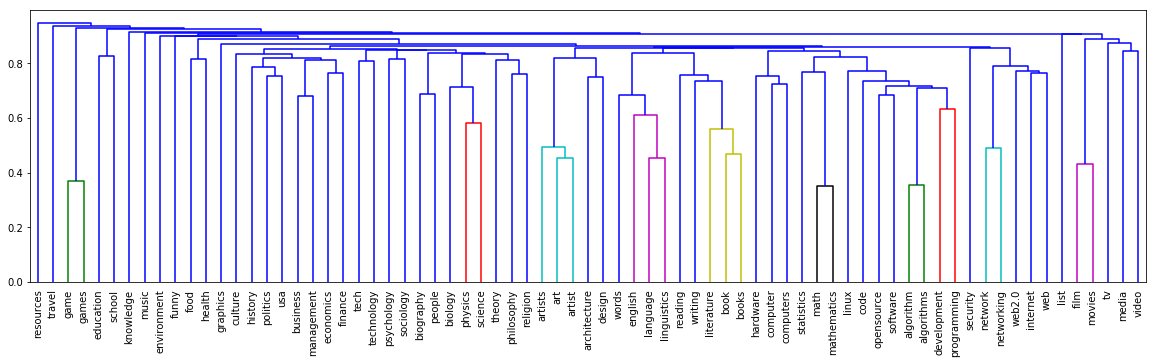

In [19]:
Z = linkage(M_tag.T, method='single', metric='cosine')
plot_dendogram(Z)

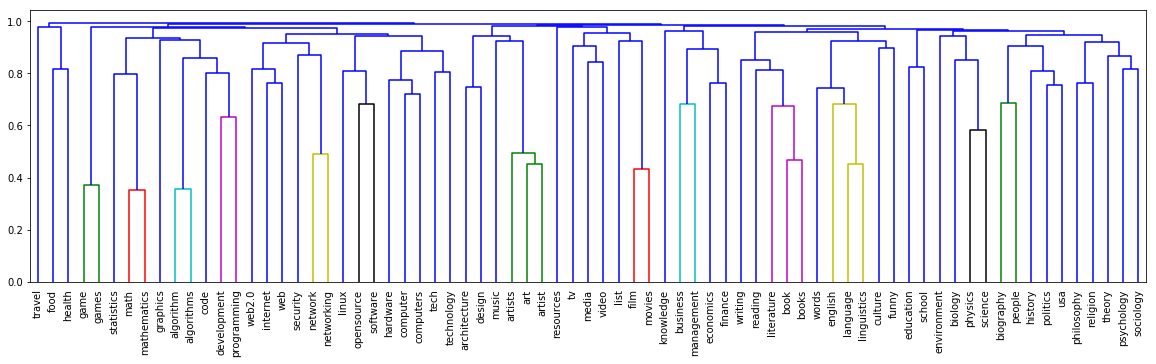

In [20]:
Z = linkage(M_tag.T, method='average', metric='cosine')
plot_dendogram(Z)

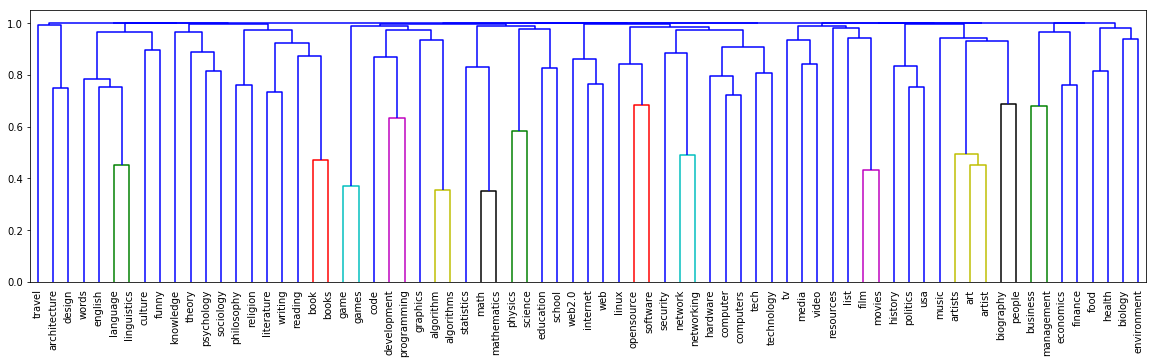

In [21]:
Z = linkage(M_tag.T, method='complete', metric='cosine')
plot_dendogram(Z)

All 3 results now show a great improvement with mmore logical clustering. It is hard to say which is preferable, although the distance between english/language/linguistics and literature/reading/writing makes the "complete" clustering slightly less appropriate than "single"/"mean". Biology tag also seems to further away from science than it should be in "complete". Perhaps the fact that "complete" uses the farthest pair of points makes it more susceptible to outliers, or points that are harder to cluster, especially in this scenario where we have relatively few data points ~70.

Using than over results as a reference point we will now define a manual mapping of tag types to reduce our total number of classes. 

In [28]:
tag_map = dict(
    literature='literature',  
    book='literature', 
    books='literature', 
    writing='literature', 
    reading='literature',
    science='science', 
    biology='science', 
    physics='science', 
    art='art', 
    artist='art', 
    artists='art', 
    film='film', 
    movies='film',
    game='game', 
    games='game', 
    math='math', 
    mathematics='math', 
    statistics='math', 
    programming='programming', 
    code='programming', 
    algorithm='programming',
    algorithms='programming', 
    development='programming', 
    computer='technology', 
    computers='technology', 
    hardware='technology', 
    tech='technology', 
    technology='technology', 
    music='music', 
    tv='media', 
    media='media', 
    video='media', 
    biography='people', 
    people='people', 
    politics='politics', 
    history='history',
    philosophy='philosophy', 
    religion='religion', 
    finance='economics', 
    economics='economics', 
    english='language', 
    language='language', 
    linguistics='language'
    ) 

Our original objective was to reduce/merge our tag types to provide us with a less granular taxonomy, as this will be useful when validating our document clustering results. 

We have now reduced the number of tag types from 73 to 17 (with some tags excluded altogether). These mapped tags will now be added to our tag_meta_dict and saved out as a new json. 

In [31]:
for doc_id, meta in tag_meta_dict.items():
    # finding the most common tag for document 
    best_tag = max(meta['tags'], key=meta['tags'].get)
    # finding the new tag mapping where available 
    mapped_tag = tag_map.get(best_tag, 'NA')
    tag_meta_dict[doc_id]['mapped_tag'] = mapped_tag

In [32]:
tag_meta_dict[list(tag_meta_dict)[0]]

{'mapped_tag': 'history',
 'tags': {'design': 0.2857142857142857, 'history': 0.35714285714285715},
 'title': 'Hermann Zapf',
 'user_count': '14'}